In [1]:
!pip install optuna


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False,gamma=1):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = gamma # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [3]:
import numpy as np
from scipy.special import softmax

def sarsa(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using SARSA.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run SARSA for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    # initialize the state-action value function and the state counts
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))
    
    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):

        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        # for each new episode, start at the given start state
        state = int(model.start_state_seq)
        # sample first action
        action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            # initialize p and r
            p, r = 0, np.random.random()
            # sample the next state according to the action and the
            # probability of the transition
            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break
            # sample the next action
            next_action = sample_action(Q, next_state, model.num_actions, epsilon, temperature, action_strategy)
            # Calculate the temporal difference and update Q function
            Q[state, action] += alpha * (model.R[state] + model.gamma * Q[next_state, next_action] - Q[state, action])
            # End episode is state is a terminal state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

            # count the state visits
            state_counts[state] += 1

            # store the previous state and action
            state = next_state
            action = next_action

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    # determine the q function and policy
    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

def sample_action(Q, state, num_actions, epsilon, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Action selection based on the specified strategy.

    Parameters
    ----------
    Q : numpy array of shape (N, num_actions)
        Q function for the environment where N is the total number of states.

    state : int
        The current state.

    num_actions : int
        The number of actions.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    action : int
        Number representing the selected action between 0 and num_actions.
    """
    if action_strategy == 'epsilon-greedy':
        if np.random.random() < epsilon:
            action = np.random.randint(0, num_actions)
        else:
            action = np.argmax(Q[state, :])
    elif action_strategy == 'softmax':
        action_values = Q[state, :]
        probabilities = softmax(action_values / temperature)
        action = np.random.choice(np.arange(num_actions), p=probabilities)
    else:
        raise ValueError("Invalid action_strategy. Use 'epsilon-greedy' or 'softmax'.")

    return action


def qlearning(model, alpha=0.5, epsilon=0.1, maxiter=100, maxeps=1000, temperature=1.0, action_strategy='epsilon-greedy'):
    """
    Solves the supplied environment using Q-learning.

    Parameters
    ----------
    model : python object
        Holds information about the environment to solve
        such as the reward structure and the transition dynamics.

    alpha : float
        Algorithm learning rate. Defaults to 0.5.

    epsilon : float
        Probability that a random action is selected. epsilon must be
        in the interval [0,1] where 0 means that the action is selected
        in a completely greedy manner and 1 means the action is always
        selected randomly.

    maxiter : int
        The maximum number of iterations to perform per episode.
        Defaults to 100.

    maxeps : int
        The number of episodes to run Q-learning for.
        Defaults to 1000.

    temperature : float, optional
        Controls the level of exploration. Higher temperature leads to more
        exploration, while lower temperature makes the action selection more
        deterministic. Defaults to 1.0.

    action_strategy : str, optional
        Action selection strategy: 'epsilon-greedy' or 'softmax'.
        Defaults to 'epsilon-greedy'.

    Returns
    -------
    q : numpy array of shape (N, 1)
        The state-action value for the environment where N is the
        total number of states.

    pi : numpy array of shape (N, 1)
        Optimal policy for the environment where N is the total
        number of states.

    state_counts : numpy array of shape (N, 1)
        Counts of the number of times each state is visited.

    total_steps_per_episode : list
        List containing the total steps per episode.

    total_rewards_per_episode : list
        List containing the total rewards per episode.
    """
    Q = np.zeros((model.num_states, model.num_actions))
    state_counts = np.zeros((model.num_states, 1))

    total_steps_per_episode = []
    total_rewards_per_episode = []

    for i in range(maxeps):
        if np.mod(i, 1000) == 0:
            print("Running episode %i." % i)

        state = int(model.start_state_seq)
        episode_steps = 0
        episode_rewards = 0

        for j in range(maxiter):
            action = sample_action(Q, state, model.num_actions, epsilon, temperature, action_strategy)

            p, r = 0, np.random.random()

            for next_state in range(model.num_states):
                p += model.P[state, next_state, action]
                if r <= p:
                    break

            Q[state, action] += alpha * (model.R[state] + model.gamma * np.max(Q[next_state, :]) - Q[state, action])

            state_counts[state] += 1

            state = next_state
            episode_steps += 1
            episode_rewards += model.R[state]

            if np.any(state == model.goal_states_seq):
                break

        total_steps_per_episode.append(int(episode_steps))
        total_rewards_per_episode.append(int(episode_rewards))

    q = np.max(Q, axis=1).reshape(-1, 1)
    pi = np.argmax(Q, axis=1).reshape(-1, 1)

    return q, pi, state_counts, total_steps_per_episode, total_rewards_per_episode

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
from plots import plot_gridworld

In [7]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                              bias=0.5)

env_0 = gw.create_gridworld()


In [5]:
import optuna

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5, log=True)
    g=trial.suggest_float('gamma',0.5,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Epsilon = {epsilon},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                    bias=0.5)

    env_0 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts, steps, rewards = sarsa(env_0, alpha=alpha, epsilon=epsilon, maxiter=100, maxeps=5000)
        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters


[I 2024-02-27 14:02:47,215] A new study created in memory with name: no-name-930c39f0-8093-4aa2-8e92-1109a18e22b4


Trial 0: Alpha = 0.10249306583175621, Epsilon = 0.34754619489385385,Gamma=0.9197809545389137
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:03:05,116] Trial 0 finished with value: 133489.9 and parameters: {'alpha': 0.10249306583175621, 'epsilon': 0.34754619489385385, 'gamma': 0.9197809545389137}. Best is trial 0 with value: 133489.9.


Trial 1: Alpha = 0.18547959423157195, Epsilon = 0.31458993668628177,Gamma=0.7689444932845287
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:03:24,174] Trial 1 finished with value: 173095.40000000002 and parameters: {'alpha': 0.18547959423157195, 'epsilon': 0.31458993668628177, 'gamma': 0.7689444932845287}. Best is trial 0 with value: 133489.9.


Trial 2: Alpha = 0.48411406300791965, Epsilon = 0.2536465253830082,Gamma=0.746665541937919
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:03:50,197] Trial 2 finished with value: 239440.6 and parameters: {'alpha': 0.48411406300791965, 'epsilon': 0.2536465253830082, 'gamma': 0.746665541937919}. Best is trial 0 with value: 133489.9.


Trial 3: Alpha = 0.4526717828438167, Epsilon = 0.1371267925221925,Gamma=0.8880839509990776
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:04:03,787] Trial 3 finished with value: 70598.5 and parameters: {'alpha': 0.4526717828438167, 'epsilon': 0.1371267925221925, 'gamma': 0.8880839509990776}. Best is trial 3 with value: 70598.5.


Trial 4: Alpha = 0.1878619292254659, Epsilon = 0.25570297063029646,Gamma=0.8243423304060812
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 14:04:18,552] Trial 4 finished with value: 107821.0 and parameters: {'alpha': 0.1878619292254659, 'epsilon': 0.25570297063029646, 'gamma': 0.8243423304060812}. Best is trial 3 with value: 70598.5.


Running episode 4000.
Trial 5: Alpha = 0.33107502489506047, Epsilon = 0.24009203907267762,Gamma=0.6134395369131227
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:05:02,304] Trial 5 finished with value: 418574.4 and parameters: {'alpha': 0.33107502489506047, 'epsilon': 0.24009203907267762, 'gamma': 0.6134395369131227}. Best is trial 3 with value: 70598.5.


Trial 6: Alpha = 0.3732069867006919, Epsilon = 0.12125925350247928,Gamma=0.9193384763624092
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:05:15,669] Trial 6 finished with value: 63330.1 and parameters: {'alpha': 0.3732069867006919, 'epsilon': 0.12125925350247928, 'gamma': 0.9193384763624092}. Best is trial 6 with value: 63330.1.


Trial 7: Alpha = 0.11385843886674567, Epsilon = 0.17556327318259243,Gamma=0.6112619379545965
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:05:44,391] Trial 7 finished with value: 287787.9 and parameters: {'alpha': 0.11385843886674567, 'epsilon': 0.17556327318259243, 'gamma': 0.6112619379545965}. Best is trial 6 with value: 63330.1.


Trial 8: Alpha = 0.1354392699453555, Epsilon = 0.20039963038340422,Gamma=0.6584827296537
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:06:11,398] Trial 8 finished with value: 271206.1 and parameters: {'alpha': 0.1354392699453555, 'epsilon': 0.20039963038340422, 'gamma': 0.6584827296537}. Best is trial 6 with value: 63330.1.


Trial 9: Alpha = 0.23229907063960797, Epsilon = 0.17691367298066443,Gamma=0.8232887934378931
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 14:06:25,449] Trial 9 finished with value: 80882.1 and parameters: {'alpha': 0.23229907063960797, 'epsilon': 0.17691367298066443, 'gamma': 0.8232887934378931}. Best is trial 6 with value: 63330.1.


Running episode 4000.
Trial 10: Alpha = 0.32474778065210186, Epsilon = 0.10556530884078302,Gamma=0.5047272731293145
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:07:13,804] Trial 10 finished with value: 460349.6 and parameters: {'alpha': 0.32474778065210186, 'epsilon': 0.10556530884078302, 'gamma': 0.5047272731293145}. Best is trial 6 with value: 63330.1.


Trial 11: Alpha = 0.4723380982995094, Epsilon = 0.11402068003060284,Gamma=0.911898840747177
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:07:26,340] Trial 11 finished with value: 70059.0 and parameters: {'alpha': 0.4723380982995094, 'epsilon': 0.11402068003060284, 'gamma': 0.911898840747177}. Best is trial 6 with value: 63330.1.


Trial 12: Alpha = 0.3544136926069417, Epsilon = 0.10093888158992086,Gamma=0.967836306927575
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:07:38,976] Trial 12 finished with value: 64730.9 and parameters: {'alpha': 0.3544136926069417, 'epsilon': 0.10093888158992086, 'gamma': 0.967836306927575}. Best is trial 6 with value: 63330.1.


Trial 13: Alpha = 0.32590984126990136, Epsilon = 0.13401325551296192,Gamma=0.9988467544745592
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:07:56,214] Trial 13 finished with value: 100793.29999999999 and parameters: {'alpha': 0.32590984126990136, 'epsilon': 0.13401325551296192, 'gamma': 0.9988467544745592}. Best is trial 6 with value: 63330.1.


Trial 14: Alpha = 0.26552121808365364, Epsilon = 0.44681493954594514,Gamma=0.9852087756201312
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:08:17,190] Trial 14 finished with value: 187430.7 and parameters: {'alpha': 0.26552121808365364, 'epsilon': 0.44681493954594514, 'gamma': 0.9852087756201312}. Best is trial 6 with value: 63330.1.


Trial 15: Alpha = 0.3865617197418298, Epsilon = 0.10042865364021575,Gamma=0.8339971272743284
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:08:29,822] Trial 15 finished with value: 63872.700000000004 and parameters: {'alpha': 0.3865617197418298, 'epsilon': 0.10042865364021575, 'gamma': 0.8339971272743284}. Best is trial 6 with value: 63330.1.


Trial 16: Alpha = 0.3966579142828318, Epsilon = 0.13761099552590147,Gamma=0.8315078297825841
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:08:43,400] Trial 16 finished with value: 75982.5 and parameters: {'alpha': 0.3966579142828318, 'epsilon': 0.13761099552590147, 'gamma': 0.8315078297825841}. Best is trial 6 with value: 63330.1.


Trial 17: Alpha = 0.277359407886335, Epsilon = 0.12351030069690991,Gamma=0.7063102022470475
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:08:56,157] Trial 17 finished with value: 87476.4 and parameters: {'alpha': 0.277359407886335, 'epsilon': 0.12351030069690991, 'gamma': 0.7063102022470475}. Best is trial 6 with value: 63330.1.


Trial 18: Alpha = 0.40213969555923534, Epsilon = 0.16608280452593815,Gamma=0.8771978053219306
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:09:09,586] Trial 18 finished with value: 78438.1 and parameters: {'alpha': 0.40213969555923534, 'epsilon': 0.16608280452593815, 'gamma': 0.8771978053219306}. Best is trial 6 with value: 63330.1.


Trial 19: Alpha = 0.2586302477543737, Epsilon = 0.15316654320611536,Gamma=0.7576741929514114
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:09:23,212] Trial 19 finished with value: 84596.1 and parameters: {'alpha': 0.2586302477543737, 'epsilon': 0.15316654320611536, 'gamma': 0.7576741929514114}. Best is trial 6 with value: 63330.1.


In [8]:

best_alpha = study.best_params['alpha']
best_epsilon = study.best_params['epsilon']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.3732069867006919
Best Epsilon: 0.12125925350247928
Best gamma: 0.9193384763624092


In [9]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_0 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_0, alpha=best_alpha, epsilon=best_epsilon, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [10]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


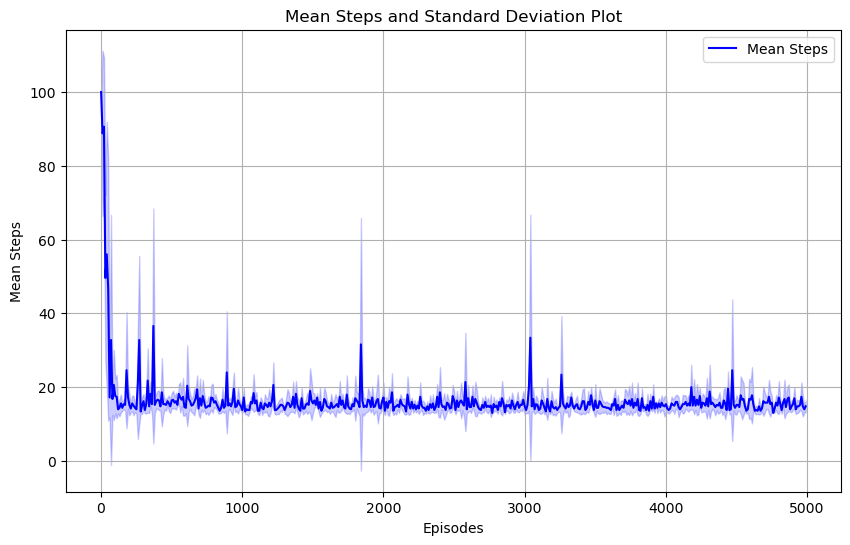

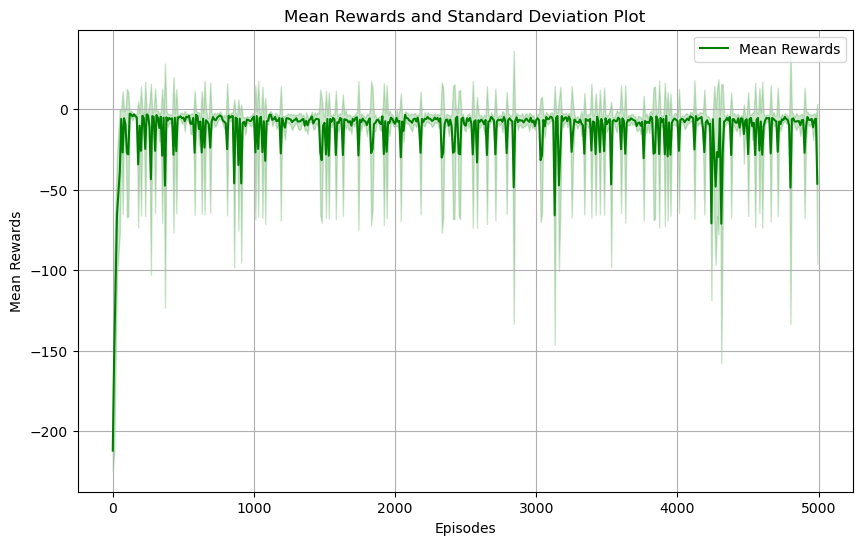

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


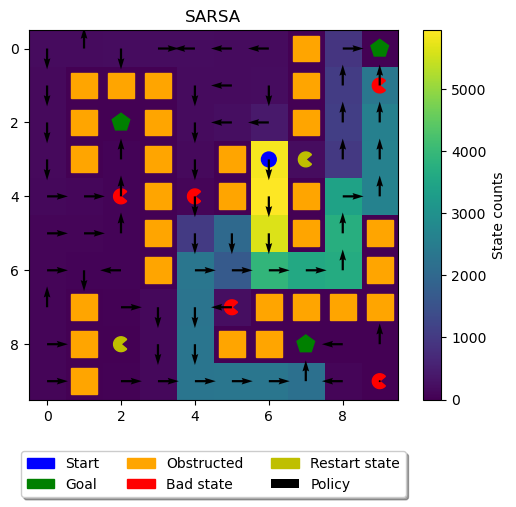

In [12]:
plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="SARSA")

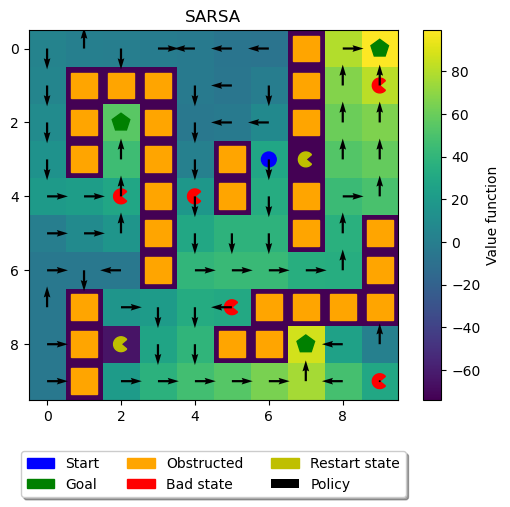

In [13]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="SARSA")

In [14]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    temp = trial.suggest_float('temperature',0.1,1, log=True)
    g=trial.suggest_float('gamma',0.5,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Temperature = {temp},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                    bias=0.5)

    env_0 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts,steps,rewards = sarsa(env_0, alpha=alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=temp)

        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials

# Get the best hyperparameters


[I 2024-02-27 14:09:35,952] A new study created in memory with name: no-name-1de717e6-146d-4113-a108-9ff98b1caa2b


Trial 0: Alpha = 0.4886726484417015, Temperature = 0.5647306859829788,Gamma=0.7343304602858325
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:10:11,686] Trial 0 finished with value: 101837.3 and parameters: {'alpha': 0.4886726484417015, 'temperature': 0.5647306859829788, 'gamma': 0.7343304602858325}. Best is trial 0 with value: 101837.3.


Trial 1: Alpha = 0.36094522168149684, Temperature = 0.5590799316495595,Gamma=0.9884579295979841
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:10:33,326] Trial 1 finished with value: 42324.5 and parameters: {'alpha': 0.36094522168149684, 'temperature': 0.5590799316495595, 'gamma': 0.9884579295979841}. Best is trial 1 with value: 42324.5.


Trial 2: Alpha = 0.2297292217543245, Temperature = 0.2341712868185429,Gamma=0.8305568816110765
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:10:55,193] Trial 2 finished with value: 45007.399999999994 and parameters: {'alpha': 0.2297292217543245, 'temperature': 0.2341712868185429, 'gamma': 0.8305568816110765}. Best is trial 1 with value: 42324.5.


Trial 3: Alpha = 0.12606325960952602, Temperature = 0.15618681011260654,Gamma=0.742604320139938
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:11:19,369] Trial 3 finished with value: 52543.0 and parameters: {'alpha': 0.12606325960952602, 'temperature': 0.15618681011260654, 'gamma': 0.742604320139938}. Best is trial 1 with value: 42324.5.


Trial 4: Alpha = 0.19497464599002293, Temperature = 0.3457234821113594,Gamma=0.5802325566323423
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:12:49,528] Trial 4 finished with value: 336079.7 and parameters: {'alpha': 0.19497464599002293, 'temperature': 0.3457234821113594, 'gamma': 0.5802325566323423}. Best is trial 1 with value: 42324.5.


Trial 5: Alpha = 0.11184784167094322, Temperature = 0.9553076061906037,Gamma=0.6150412622639749
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:14:29,828] Trial 5 finished with value: 385487.5 and parameters: {'alpha': 0.11184784167094322, 'temperature': 0.9553076061906037, 'gamma': 0.6150412622639749}. Best is trial 1 with value: 42324.5.


Trial 6: Alpha = 0.28770024542434885, Temperature = 0.1521413964824595,Gamma=0.863842324452318
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:14:51,846] Trial 6 finished with value: 42711.3 and parameters: {'alpha': 0.28770024542434885, 'temperature': 0.1521413964824595, 'gamma': 0.863842324452318}. Best is trial 1 with value: 42324.5.


Trial 7: Alpha = 0.4273554444046217, Temperature = 0.5193814626469766,Gamma=0.9795954101458519
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:15:12,651] Trial 7 finished with value: 41624.799999999996 and parameters: {'alpha': 0.4273554444046217, 'temperature': 0.5193814626469766, 'gamma': 0.9795954101458519}. Best is trial 7 with value: 41624.799999999996.


Trial 8: Alpha = 0.27968868563232097, Temperature = 0.3554494857809267,Gamma=0.9654147502050364
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:15:33,820] Trial 8 finished with value: 42883.799999999996 and parameters: {'alpha': 0.27968868563232097, 'temperature': 0.3554494857809267, 'gamma': 0.9654147502050364}. Best is trial 7 with value: 41624.799999999996.


Trial 9: Alpha = 0.39324313856202925, Temperature = 0.40895309679958364,Gamma=0.9377058611509997
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:15:55,050] Trial 9 finished with value: 41982.5 and parameters: {'alpha': 0.39324313856202925, 'temperature': 0.40895309679958364, 'gamma': 0.9377058611509997}. Best is trial 7 with value: 41624.799999999996.


Trial 10: Alpha = 0.17506682991214675, Temperature = 0.9855342386454421,Gamma=0.5137519046728576
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:17:47,537] Trial 10 finished with value: 428674.6 and parameters: {'alpha': 0.17506682991214675, 'temperature': 0.9855342386454421, 'gamma': 0.5137519046728576}. Best is trial 7 with value: 41624.799999999996.


Trial 11: Alpha = 0.4516035651651978, Temperature = 0.5128143510407185,Gamma=0.866438937804427
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:18:09,644] Trial 11 finished with value: 44844.100000000006 and parameters: {'alpha': 0.4516035651651978, 'temperature': 0.5128143510407185, 'gamma': 0.866438937804427}. Best is trial 7 with value: 41624.799999999996.


Trial 12: Alpha = 0.3716839429707865, Temperature = 0.25225092447224917,Gamma=0.9167373437255232
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:18:31,676] Trial 12 finished with value: 44442.7 and parameters: {'alpha': 0.3716839429707865, 'temperature': 0.25225092447224917, 'gamma': 0.9167373437255232}. Best is trial 7 with value: 41624.799999999996.


Trial 13: Alpha = 0.3741848797807694, Temperature = 0.47250495316977964,Gamma=0.7938895163552715
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:18:55,106] Trial 13 finished with value: 45866.2 and parameters: {'alpha': 0.3741848797807694, 'temperature': 0.47250495316977964, 'gamma': 0.7938895163552715}. Best is trial 7 with value: 41624.799999999996.


Trial 14: Alpha = 0.278495303767608, Temperature = 0.6437199689127331,Gamma=0.9991250257931595
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:19:17,535] Trial 14 finished with value: 45923.8 and parameters: {'alpha': 0.278495303767608, 'temperature': 0.6437199689127331, 'gamma': 0.9991250257931595}. Best is trial 7 with value: 41624.799999999996.


Trial 15: Alpha = 0.416460674248458, Temperature = 0.729234276444649,Gamma=0.692053533883275
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:20:26,703] Trial 15 finished with value: 239666.09999999998 and parameters: {'alpha': 0.416460674248458, 'temperature': 0.729234276444649, 'gamma': 0.692053533883275}. Best is trial 7 with value: 41624.799999999996.


Trial 16: Alpha = 0.32079254763750625, Temperature = 0.3952332483519463,Gamma=0.8976673461034729
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:20:49,483] Trial 16 finished with value: 42925.0 and parameters: {'alpha': 0.32079254763750625, 'temperature': 0.3952332483519463, 'gamma': 0.8976673461034729}. Best is trial 7 with value: 41624.799999999996.


Trial 17: Alpha = 0.2321348095259977, Temperature = 0.2526764226367184,Gamma=0.6592240380078404
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:21:46,270] Trial 17 finished with value: 189201.40000000002 and parameters: {'alpha': 0.2321348095259977, 'temperature': 0.2526764226367184, 'gamma': 0.6592240380078404}. Best is trial 7 with value: 41624.799999999996.


Trial 18: Alpha = 0.14974417423420705, Temperature = 0.7694649307852097,Gamma=0.7902349844839031
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:22:14,841] Trial 18 finished with value: 66722.29999999999 and parameters: {'alpha': 0.14974417423420705, 'temperature': 0.7694649307852097, 'gamma': 0.7902349844839031}. Best is trial 7 with value: 41624.799999999996.


Trial 19: Alpha = 0.4438437200642047, Temperature = 0.10407623510346754,Gamma=0.9249606927124641
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:22:37,334] Trial 19 finished with value: 41081.0 and parameters: {'alpha': 0.4438437200642047, 'temperature': 0.10407623510346754, 'gamma': 0.9249606927124641}. Best is trial 19 with value: 41081.0.


In [15]:

best_alpha = study.best_params['alpha']
best_temp = study.best_params['temperature']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best temp:", best_temp)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.4438437200642047
Best temp: 0.10407623510346754
Best gamma: 0.9249606927124641


In [16]:
num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_0 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_0, alpha=best_alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=best_temp)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)

Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [17]:
avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


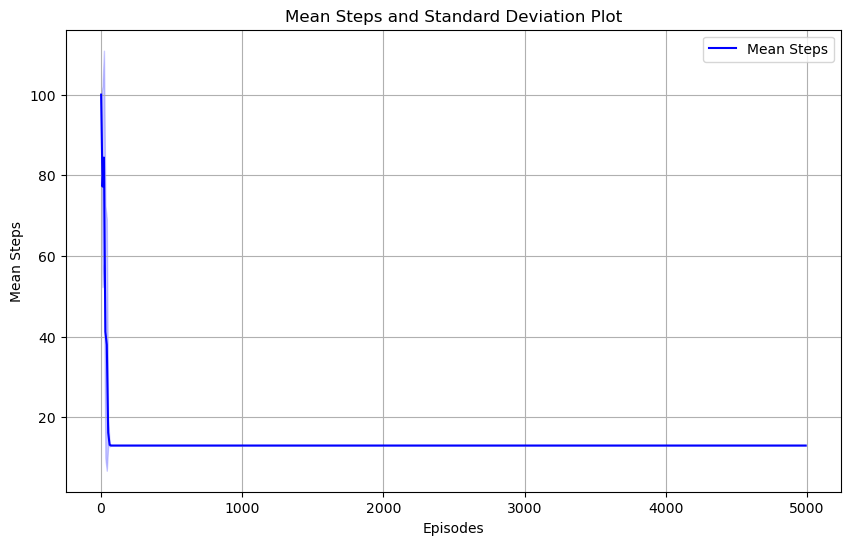

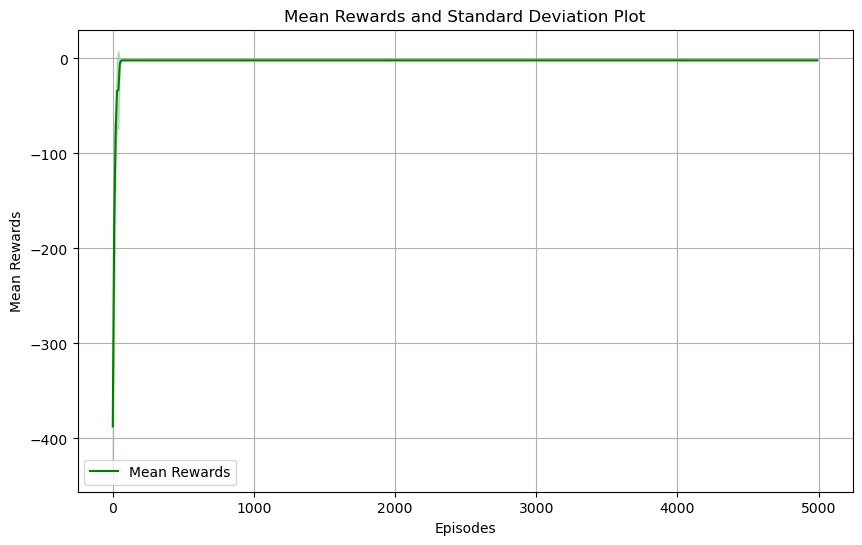

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


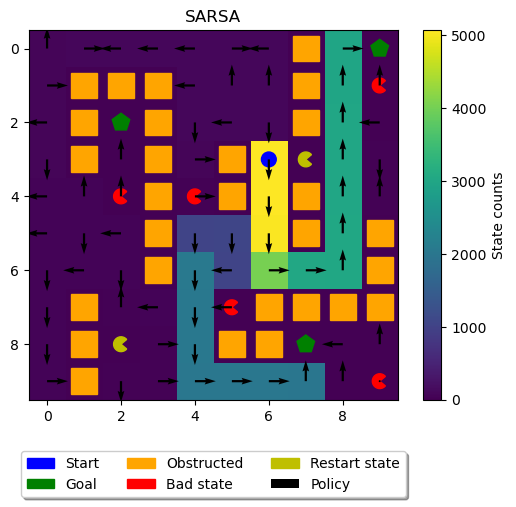

In [19]:

plot_gridworld(env_0, policy=pi, state_counts=avg_state, title="SARSA")

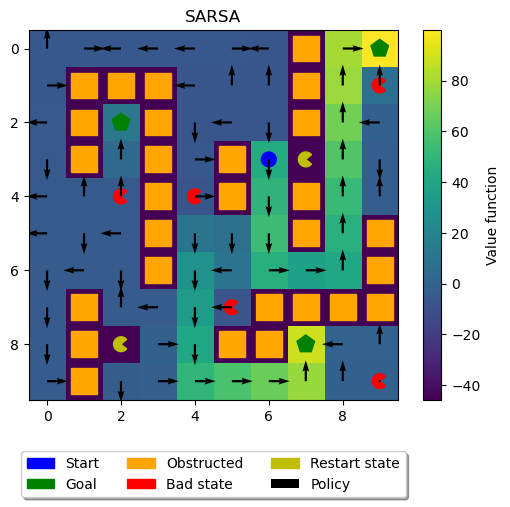

In [20]:

plot_gridworld(env_0, policy=pi,value_function=avg_q, title="SARSA")

In [6]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[0,4]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                              bias=0.5)

env_1 = gw.create_gridworld()


In [30]:

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    epsilon = trial.suggest_float('epsilon', 0.1, 0.5, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Epsilon = {epsilon},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

    env_1 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts, steps, rewards = sarsa(env_1, alpha=alpha, epsilon=epsilon, maxiter=100, maxeps=5000)
        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials



[I 2024-02-27 14:29:33,523] A new study created in memory with name: no-name-a01e8b3f-1387-4c3e-873a-3a344f219a46


Trial 0: Alpha = 0.1879622298033186, Epsilon = 0.44175190329070035,Gamma=0.956681372515879
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:29:48,724] Trial 0 finished with value: 133073.7 and parameters: {'alpha': 0.1879622298033186, 'epsilon': 0.44175190329070035, 'gamma': 0.956681372515879}. Best is trial 0 with value: 133073.7.


Trial 1: Alpha = 0.10385087760729575, Epsilon = 0.48291139354987167,Gamma=0.8540087299710133
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:30:04,786] Trial 1 finished with value: 145244.59999999998 and parameters: {'alpha': 0.10385087760729575, 'epsilon': 0.48291139354987167, 'gamma': 0.8540087299710133}. Best is trial 0 with value: 133073.7.


Trial 2: Alpha = 0.3685553878099881, Epsilon = 0.3423705210809391,Gamma=0.8730584341464844
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:30:21,909] Trial 2 finished with value: 151610.9 and parameters: {'alpha': 0.3685553878099881, 'epsilon': 0.3423705210809391, 'gamma': 0.8730584341464844}. Best is trial 0 with value: 133073.7.


Trial 3: Alpha = 0.23156198157363284, Epsilon = 0.12237420464542759,Gamma=0.9082403765422815
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:30:34,772] Trial 3 finished with value: 96124.5 and parameters: {'alpha': 0.23156198157363284, 'epsilon': 0.12237420464542759, 'gamma': 0.9082403765422815}. Best is trial 3 with value: 96124.5.


Trial 4: Alpha = 0.2120266012153679, Epsilon = 0.13958419703357422,Gamma=0.9335675132725421
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:30:45,930] Trial 4 finished with value: 88196.9 and parameters: {'alpha': 0.2120266012153679, 'epsilon': 0.13958419703357422, 'gamma': 0.9335675132725421}. Best is trial 4 with value: 88196.9.


Trial 5: Alpha = 0.40714636645560837, Epsilon = 0.12686653449837387,Gamma=0.9240756986173049
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:31:03,727] Trial 5 finished with value: 152449.2 and parameters: {'alpha': 0.40714636645560837, 'epsilon': 0.12686653449837387, 'gamma': 0.9240756986173049}. Best is trial 4 with value: 88196.9.


Trial 6: Alpha = 0.10327041503592528, Epsilon = 0.1397514160696153,Gamma=0.9764186693350339
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:31:13,343] Trial 6 finished with value: 75606.8 and parameters: {'alpha': 0.10327041503592528, 'epsilon': 0.1397514160696153, 'gamma': 0.9764186693350339}. Best is trial 6 with value: 75606.8.


Trial 7: Alpha = 0.4258324754387363, Epsilon = 0.14560901636986495,Gamma=0.8789375556177241
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:31:32,481] Trial 7 finished with value: 164927.6 and parameters: {'alpha': 0.4258324754387363, 'epsilon': 0.14560901636986495, 'gamma': 0.8789375556177241}. Best is trial 6 with value: 75606.8.


Trial 8: Alpha = 0.1516259621975216, Epsilon = 0.20665796103620315,Gamma=0.8310332278856706
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:31:43,377] Trial 8 finished with value: 88524.4 and parameters: {'alpha': 0.1516259621975216, 'epsilon': 0.20665796103620315, 'gamma': 0.8310332278856706}. Best is trial 6 with value: 75606.8.


Trial 9: Alpha = 0.4872967479643091, Epsilon = 0.1300982761203064,Gamma=0.8736681233410151
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:32:06,792] Trial 9 finished with value: 200638.3 and parameters: {'alpha': 0.4872967479643091, 'epsilon': 0.1300982761203064, 'gamma': 0.8736681233410151}. Best is trial 6 with value: 75606.8.


Trial 10: Alpha = 0.10050039235783498, Epsilon = 0.21209045802148557,Gamma=0.9932871436844364
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.


[I 2024-02-27 14:32:17,997] Trial 10 finished with value: 84960.1 and parameters: {'alpha': 0.10050039235783498, 'epsilon': 0.21209045802148557, 'gamma': 0.9932871436844364}. Best is trial 6 with value: 75606.8.


Running episode 3000.
Running episode 4000.
Trial 11: Alpha = 0.10247715253273917, Epsilon = 0.21084808834910596,Gamma=0.9946386220939164
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 14:32:28,915] Trial 11 finished with value: 85182.4 and parameters: {'alpha': 0.10247715253273917, 'epsilon': 0.21084808834910596, 'gamma': 0.9946386220939164}. Best is trial 6 with value: 75606.8.


Running episode 4000.
Trial 12: Alpha = 0.1324398842669882, Epsilon = 0.2650670316405213,Gamma=0.9977935031911517
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:32:40,879] Trial 12 finished with value: 92842.6 and parameters: {'alpha': 0.1324398842669882, 'epsilon': 0.2650670316405213, 'gamma': 0.9977935031911517}. Best is trial 6 with value: 75606.8.


Trial 13: Alpha = 0.1411155209749329, Epsilon = 0.1716677350863464,Gamma=0.9599207447460708
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:32:51,217] Trial 13 finished with value: 78428.29999999999 and parameters: {'alpha': 0.1411155209749329, 'epsilon': 0.1716677350863464, 'gamma': 0.9599207447460708}. Best is trial 6 with value: 75606.8.


Trial 14: Alpha = 0.14607789299061255, Epsilon = 0.16635160583584854,Gamma=0.9550133134109643
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:33:02,086] Trial 14 finished with value: 78461.9 and parameters: {'alpha': 0.14607789299061255, 'epsilon': 0.16635160583584854, 'gamma': 0.9550133134109643}. Best is trial 6 with value: 75606.8.


Trial 15: Alpha = 0.29730491711458773, Epsilon = 0.10441541140104534,Gamma=0.9596369058989083
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:33:17,121] Trial 15 finished with value: 113513.9 and parameters: {'alpha': 0.29730491711458773, 'epsilon': 0.10441541140104534, 'gamma': 0.9596369058989083}. Best is trial 6 with value: 75606.8.


Trial 16: Alpha = 0.12731555750193344, Epsilon = 0.16994340029412275,Gamma=0.9696189031361483
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:33:27,062] Trial 16 finished with value: 78348.79999999999 and parameters: {'alpha': 0.12731555750193344, 'epsilon': 0.16994340029412275, 'gamma': 0.9696189031361483}. Best is trial 6 with value: 75606.8.


Trial 17: Alpha = 0.12021552609740903, Epsilon = 0.2718806528795779,Gamma=0.9302761039690743
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 14:33:38,657] Trial 17 finished with value: 94091.9 and parameters: {'alpha': 0.12021552609740903, 'epsilon': 0.2718806528795779, 'gamma': 0.9302761039690743}. Best is trial 6 with value: 75606.8.


Running episode 4000.
Trial 18: Alpha = 0.17920452820998314, Epsilon = 0.17020012520349276,Gamma=0.8045756319309887
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:33:49,139] Trial 18 finished with value: 83431.4 and parameters: {'alpha': 0.17920452820998314, 'epsilon': 0.17020012520349276, 'gamma': 0.8045756319309887}. Best is trial 6 with value: 75606.8.


Trial 19: Alpha = 0.1206669062258845, Epsilon = 0.10100490836428958,Gamma=0.9690283923463631
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:33:58,199] Trial 19 finished with value: 69876.2 and parameters: {'alpha': 0.1206669062258845, 'epsilon': 0.10100490836428958, 'gamma': 0.9690283923463631}. Best is trial 19 with value: 69876.2.


In [31]:


# Get the best hyperparameters


best_alpha = study.best_params['alpha']
best_epsilon = study.best_params['epsilon']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best Epsilon:", best_epsilon)
print("Best gamma:", best_gamma)




Best Hyperparameters:
Best Alpha: 0.1206669062258845
Best Epsilon: 0.10100490836428958
Best gamma: 0.9690283923463631


In [32]:


num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_1 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_1, alpha=best_alpha, epsilon=best_epsilon, maxiter=100, maxeps=5000)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)


Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [33]:

avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


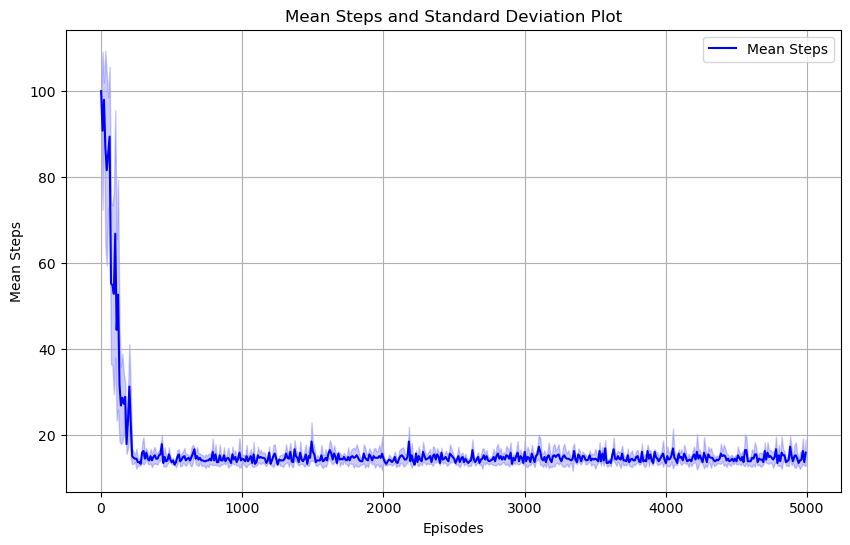

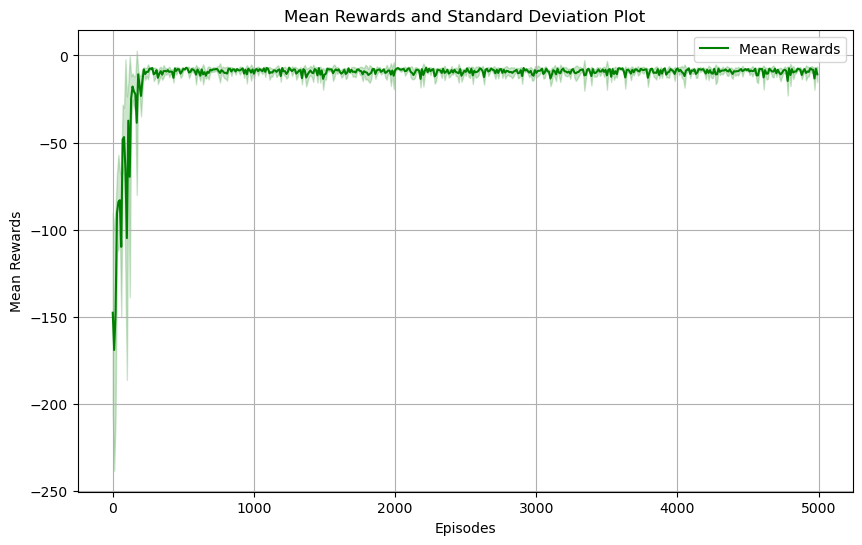

In [34]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


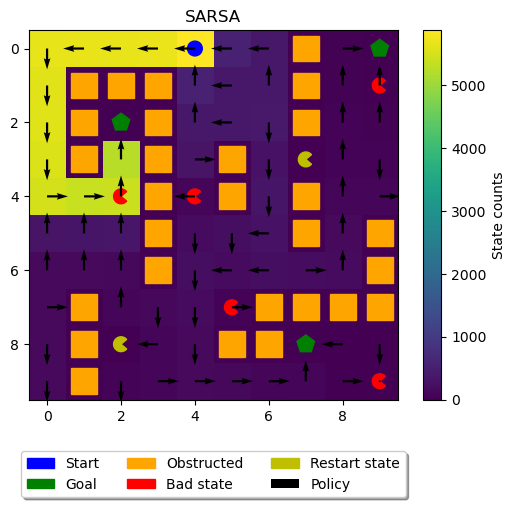

In [35]:


plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="SARSA")


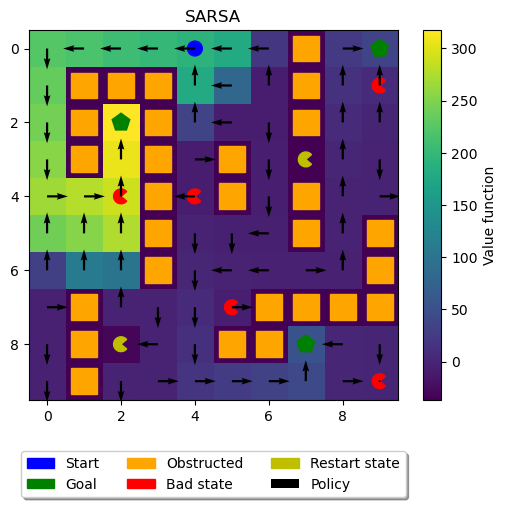

In [36]:


plot_gridworld(env_1, policy=pi,value_function=avg_q, title="SARSA")


In [37]:

def objective(trial):
    alpha = trial.suggest_float('alpha', 0.1, 0.5, log=True)
    temp = trial.suggest_float('temperature',0.1,1, log=True)
    g=trial.suggest_float('gamma',0.8,1,log=True)

    print(f"Trial {trial.number}: Alpha = {alpha}, Temperature = {temp},Gamma={g}")

    num_expts = 5
    total_rewards, total_steps, Q_func, state_visit = [], [], [], []
    gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=g)
    gw.add_obstructions(obstructed_states=obstructions,
                            bad_states=bad_states,
                            restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                    goal_reward=10,
                    bad_state_reward=-6,
                    restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=1,
                                    bias=0.5)

    env_1 = gw.create_gridworld()

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))

        q_function, pi, state_counts,steps,rewards = sarsa(env_1, alpha=alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=temp)

        total_steps.append(steps)
        total_rewards.append(rewards)
        Q_func.append(q_function)
        state_visit.append(state_counts)

    # Define a weighted combination of minimizing steps and maximizing rewards
    # Adjust the weights based on your preference
    objective_value = 0.5 * np.sum(np.sum(np.array(total_steps)),axis=0) / num_expts + 0.5 * (-np.sum(np.sum(np.array(total_rewards))) / num_expts)

    return objective_value

study = optuna.create_study(direction='minimize')  # We want to minimize the combined objective
study.optimize(objective, n_trials=20)  # You can adjust the number of trials


[I 2024-02-27 14:34:07,835] A new study created in memory with name: no-name-222846c9-9e15-49a6-9e2d-e3ac88232c08


Trial 0: Alpha = 0.48676063026960364, Temperature = 0.173159775783341,Gamma=0.8502762852053783
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:34:32,731] Trial 0 finished with value: 64377.5 and parameters: {'alpha': 0.48676063026960364, 'temperature': 0.173159775783341, 'gamma': 0.8502762852053783}. Best is trial 0 with value: 64377.5.


Trial 1: Alpha = 0.2300385092868054, Temperature = 0.1547243844387989,Gamma=0.8732886092675858
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:34:53,689] Trial 1 finished with value: 59896.2 and parameters: {'alpha': 0.2300385092868054, 'temperature': 0.1547243844387989, 'gamma': 0.8732886092675858}. Best is trial 1 with value: 59896.2.


Trial 2: Alpha = 0.17831045771557494, Temperature = 0.32096855317017225,Gamma=0.8449560563891251
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:35:17,925] Trial 2 finished with value: 67277.1 and parameters: {'alpha': 0.17831045771557494, 'temperature': 0.32096855317017225, 'gamma': 0.8449560563891251}. Best is trial 1 with value: 59896.2.


Trial 3: Alpha = 0.24565624023775515, Temperature = 0.38783414336162375,Gamma=0.9164343803436992
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:35:37,149] Trial 3 finished with value: 57413.0 and parameters: {'alpha': 0.24565624023775515, 'temperature': 0.38783414336162375, 'gamma': 0.9164343803436992}. Best is trial 3 with value: 57413.0.


Trial 4: Alpha = 0.16380793442056862, Temperature = 0.20771178713288488,Gamma=0.9253823609227934
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:35:56,705] Trial 4 finished with value: 59549.5 and parameters: {'alpha': 0.16380793442056862, 'temperature': 0.20771178713288488, 'gamma': 0.9253823609227934}. Best is trial 3 with value: 57413.0.


Trial 5: Alpha = 0.3081475674461179, Temperature = 0.542567980896235,Gamma=0.8042379290002487
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:36:17,872] Trial 5 finished with value: 65579.2 and parameters: {'alpha': 0.3081475674461179, 'temperature': 0.542567980896235, 'gamma': 0.8042379290002487}. Best is trial 3 with value: 57413.0.


Trial 6: Alpha = 0.25458558278338456, Temperature = 0.7924869508672333,Gamma=0.9255773253074474
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:36:37,746] Trial 6 finished with value: 59113.8 and parameters: {'alpha': 0.25458558278338456, 'temperature': 0.7924869508672333, 'gamma': 0.9255773253074474}. Best is trial 3 with value: 57413.0.


Trial 7: Alpha = 0.19806888178172558, Temperature = 0.1309001365170499,Gamma=0.9617775148289076
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:36:57,196] Trial 7 finished with value: 57067.4 and parameters: {'alpha': 0.19806888178172558, 'temperature': 0.1309001365170499, 'gamma': 0.9617775148289076}. Best is trial 7 with value: 57067.4.


Trial 8: Alpha = 0.18744787824849535, Temperature = 0.27112310475600104,Gamma=0.8717536131253415
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.


[I 2024-02-27 14:37:18,696] Trial 8 finished with value: 62614.2 and parameters: {'alpha': 0.18744787824849535, 'temperature': 0.27112310475600104, 'gamma': 0.8717536131253415}. Best is trial 7 with value: 57067.4.


Running episode 4000.
Trial 9: Alpha = 0.3055302610774282, Temperature = 0.11736496868229254,Gamma=0.9280775188293879
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:37:37,063] Trial 9 finished with value: 55163.799999999996 and parameters: {'alpha': 0.3055302610774282, 'temperature': 0.11736496868229254, 'gamma': 0.9280775188293879}. Best is trial 9 with value: 55163.799999999996.


Trial 10: Alpha = 0.10892986925620556, Temperature = 0.10365826845514907,Gamma=0.9903250869430157
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:37:57,072] Trial 10 finished with value: 61406.3 and parameters: {'alpha': 0.10892986925620556, 'temperature': 0.10365826845514907, 'gamma': 0.9903250869430157}. Best is trial 9 with value: 55163.799999999996.


Trial 11: Alpha = 0.4011079807661188, Temperature = 0.10586987451443743,Gamma=0.9757334090150874
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:38:18,868] Trial 11 finished with value: 59070.600000000006 and parameters: {'alpha': 0.4011079807661188, 'temperature': 0.10586987451443743, 'gamma': 0.9757334090150874}. Best is trial 9 with value: 55163.799999999996.


Trial 12: Alpha = 0.3282504708645369, Temperature = 0.14203247896659443,Gamma=0.9598319939482134
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:38:43,344] Trial 12 finished with value: 62307.8 and parameters: {'alpha': 0.3282504708645369, 'temperature': 0.14203247896659443, 'gamma': 0.9598319939482134}. Best is trial 9 with value: 55163.799999999996.


Trial 13: Alpha = 0.13480399556054737, Temperature = 0.22386642278723065,Gamma=0.9497808203297468
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:39:03,327] Trial 13 finished with value: 61166.4 and parameters: {'alpha': 0.13480399556054737, 'temperature': 0.22386642278723065, 'gamma': 0.9497808203297468}. Best is trial 9 with value: 55163.799999999996.


Trial 14: Alpha = 0.32256660162849243, Temperature = 0.12912823416612515,Gamma=0.9991332483148742
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:39:21,744] Trial 14 finished with value: 54659.2 and parameters: {'alpha': 0.32256660162849243, 'temperature': 0.12912823416612515, 'gamma': 0.9991332483148742}. Best is trial 14 with value: 54659.2.


Trial 15: Alpha = 0.3257641419548626, Temperature = 0.10194377341353165,Gamma=0.9981814442813379
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:39:44,235] Trial 15 finished with value: 59509.0 and parameters: {'alpha': 0.3257641419548626, 'temperature': 0.10194377341353165, 'gamma': 0.9981814442813379}. Best is trial 14 with value: 54659.2.


Trial 16: Alpha = 0.42307990796148764, Temperature = 0.18841452133387682,Gamma=0.9033386780401976
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:40:07,608] Trial 16 finished with value: 62013.2 and parameters: {'alpha': 0.42307990796148764, 'temperature': 0.18841452133387682, 'gamma': 0.9033386780401976}. Best is trial 14 with value: 54659.2.


Trial 17: Alpha = 0.283082769552368, Temperature = 0.4444424304938859,Gamma=0.9416674024301314
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:40:28,241] Trial 17 finished with value: 59167.399999999994 and parameters: {'alpha': 0.283082769552368, 'temperature': 0.4444424304938859, 'gamma': 0.9416674024301314}. Best is trial 14 with value: 54659.2.


Trial 18: Alpha = 0.3841114891444738, Temperature = 0.24608484662540703,Gamma=0.8970429165610581
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:40:50,563] Trial 18 finished with value: 60024.399999999994 and parameters: {'alpha': 0.3841114891444738, 'temperature': 0.24608484662540703, 'gamma': 0.8970429165610581}. Best is trial 14 with value: 54659.2.


Trial 19: Alpha = 0.49936318922249623, Temperature = 0.9533855700254621,Gamma=0.8193591259138149
Experiment: 1
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


[I 2024-02-27 14:41:11,974] Trial 19 finished with value: 68474.4 and parameters: {'alpha': 0.49936318922249623, 'temperature': 0.9533855700254621, 'gamma': 0.8193591259138149}. Best is trial 14 with value: 54659.2.


In [38]:


# Get the best hyperparameters


best_alpha = study.best_params['alpha']
best_temp = study.best_params['temperature']
best_gamma=study.best_params['gamma']

print("\nBest Hyperparameters:")
print("Best Alpha:", best_alpha)
print("Best temp:", best_temp)
print("Best gamma:", best_gamma)



Best Hyperparameters:
Best Alpha: 0.32256660162849243
Best temp: 0.12912823416612515
Best gamma: 0.9991332483148742


In [7]:
best_alpha = 0.32256660162849243
best_temp = 0.12912823416612515
best_gamma=0.9991332483148742

In [8]:


num_expts = 5
total_rewards, total_steps,Q_func,state_visit = [], [],[],[]
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False,gamma=best_gamma)
gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                                bias=0.5)

env_1 = gw.create_gridworld()

for i in range(num_expts):
    print("Experiment: %d"%(i+1))

    # TODO: run sarsa, store metrics
    #Q, episode_rewards, steps_to_completion = qlearning(env, Q, choose_action=choose_action_softmax)
    q_function, pi, state_counts,steps,rewards = sarsa(env_1, alpha=best_alpha, epsilon=0.2, maxiter=100, maxeps=5000,action_strategy="softmax",temperature=best_temp)
    total_steps.append(steps)
    total_rewards.append(rewards)
    Q_func.append(q_function)
    state_visit.append(state_counts)


#steps_average=sum(steps)/len(steps)
#reward_average=sum(rewards)/len(rewards)


Experiment: 1
Running episode 0.


/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_11949/1446210169.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state = int(model.start_state_seq)
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_11949/1446210169.py:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] += alpha * (model.R[state] + model.gamma * Q[next_state, next_action] - Q[state, action])
/var/folders/5s/q26jpnvn3yq09tjh19kkcx7h0000gn/T/ipykernel_11949/1446210169.py:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array 

Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 2
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 3
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 4
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.
Experiment: 5
Running episode 0.
Running episode 1000.
Running episode 2000.
Running episode 3000.
Running episode 4000.


In [9]:

avg_steps=np.mean(np.array(total_steps), axis=0)
std_across_steps= np.std(np.array(total_steps), axis=0)

avg_rewards=np.mean(np.array(total_rewards), axis=0)
std_across_rewards= np.std(np.array(total_rewards), axis=0)

avg_q=np.mean(np.array(Q_func), axis=0)
avg_state=np.mean(np.array(state_visit), axis=0)


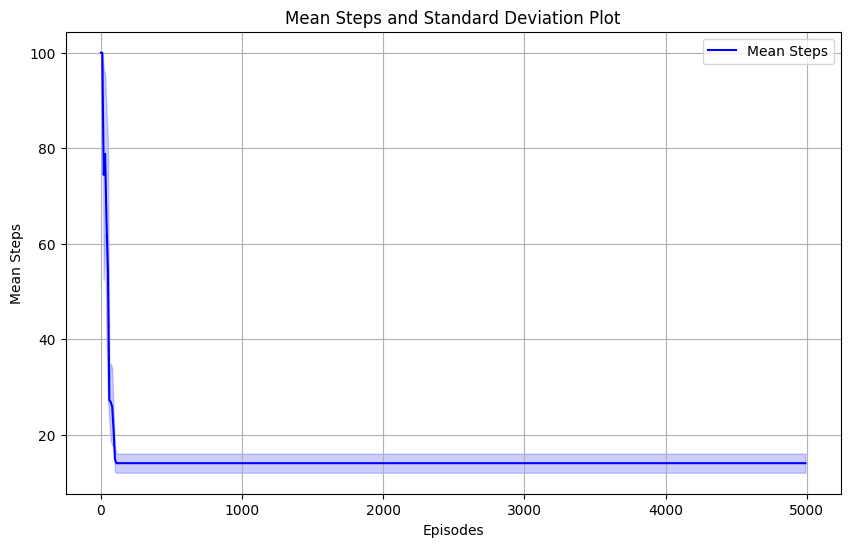

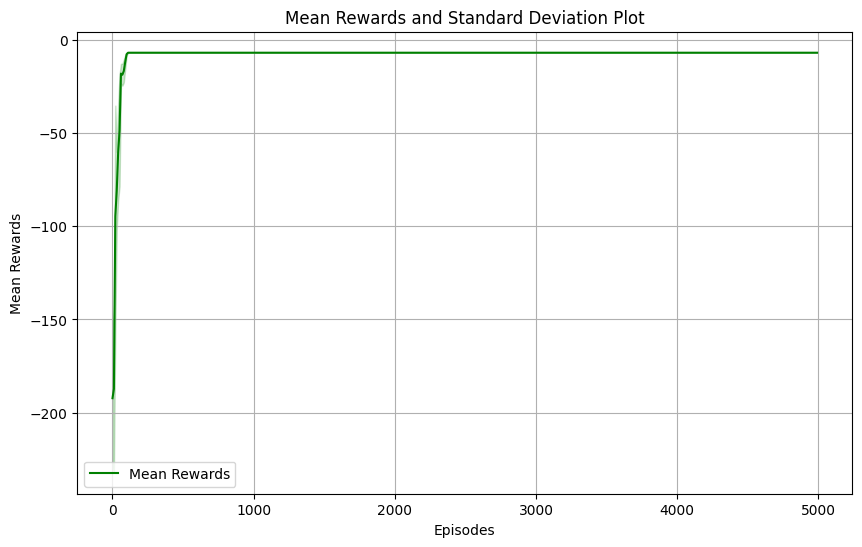

In [10]:


import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_steps, std_across_steps, avg_rewards, and std_across_rewards are defined

episodes = np.arange(1, len(avg_steps) + 1)

# Only include every 25th episode
sampled_episodes = episodes[::10]
sampled_avg_steps = avg_steps[::10]
sampled_std_across_steps = std_across_steps[::10]
sampled_avg_rewards = avg_rewards[::10]
sampled_std_across_rewards = std_across_rewards[::10]

# sampled_episodes = episodes
# sampled_avg_steps = avg_steps
# sampled_std_across_steps = std_across_steps
# sampled_avg_rewards = avg_rewards
# sampled_std_across_rewards = std_across_rewards

# Plot for mean steps
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_steps, label='Mean Steps', color='blue')
plt.fill_between(sampled_episodes, sampled_avg_steps - sampled_std_across_steps, 
                 sampled_avg_steps + sampled_std_across_steps, alpha=0.2, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Mean Steps')
plt.title('Mean Steps and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()

# Plot for mean rewards
plt.figure(figsize=(10, 6))
plt.plot(sampled_episodes, sampled_avg_rewards, label='Mean Rewards', color='green')
plt.fill_between(sampled_episodes, sampled_avg_rewards - sampled_std_across_rewards, 
                 sampled_avg_rewards + sampled_std_across_rewards, alpha=0.2, color='green')
plt.xlabel('Episodes')
plt.ylabel('Mean Rewards')
plt.title('Mean Rewards and Standard Deviation Plot')
plt.legend()
plt.grid(True)
plt.show()


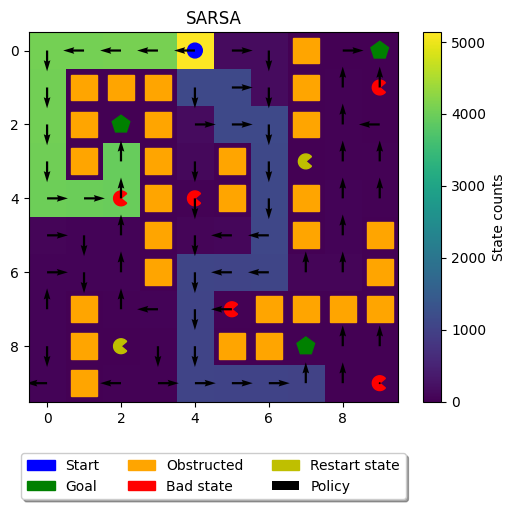

In [15]:



plot_gridworld(env_1, policy=pi, state_counts=avg_state, title="SARSA")


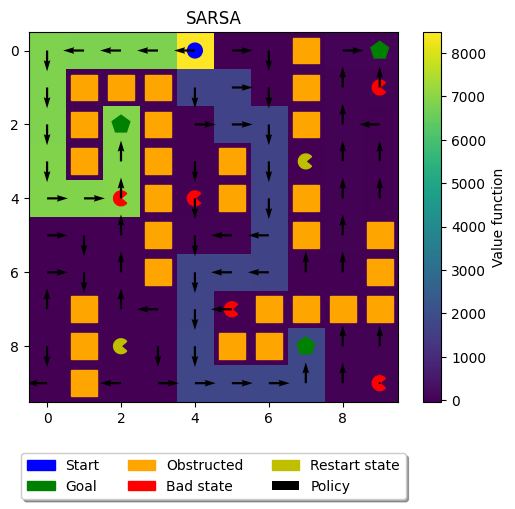

In [16]:


plot_gridworld(env_1, policy=pi,value_function=avg_q, title="SARSA")